# Image similarity estimation using a Siamese Network with a contrastive loss

**Authors:** Niklas Dörner, Beyza Cinar<br>
**Last modified:** 30.07.2023<br>
**Description:** Comparing 5 different loss functions to analyze the impact of loss functions on theperformance of Siamese Neural Networks.<br>
**References:** https://keras.io/examples/vision/siamese_contrastive/ <br>
**Dataset:** https://www.kaggle.com/datasets/yasserh/avengers-faces-dataset

## Imports

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import os
from emnist import extract_training_samples

import zipfile
import shutil
from typing import Tuple, List
from shutil import copyfile

from tqdm import tqdm
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi
from keras import backend as K

import matplotlib.pyplot as plt
from IPython.display import clear_output as cls
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model

2023-07-30 20:33:02.518575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setup for reproducability

In [2]:
seed_value= 42

os.environ['PYTHONHASHSEED']=str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Hyperparameters

In [3]:
EPOCHS = 100
BATCH_SIZE = 32
margin = 1  # Margin for contrastive loss.
DIMENSION = 20

In [4]:
# Constants
IMAGE_SIZE = 150 # size of the input image
NUM_CLASSES = 9 # number of classes at the dataset
SPLIT_SIZE = .9 # Define proportion of images used for training

In [5]:
# Data was downloaded from kaggle but the file structure was modified
# Store file paths
ORIGINAL_TRAIN_DIR = "avgrs_img/train"
ORIGINAL_TEST_DIR = "avgrs_img/test"

## Load and transform the data 

https://www.tensorflow.org/tutorials/load_data/images

https://stackoverflow.com/questions/50992702/how-to-format-x-and-y-data-from-imagedatagenerator-in-keras

In [6]:
# Training Set
train_ds = tf.keras.utils.image_dataset_from_directory(
  ORIGINAL_TRAIN_DIR,
  color_mode="grayscale", 
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=205,
  )

Found 205 files belonging to 3 classes.


In [7]:
class_names_train = train_ds.class_names
print(class_names_train)

['chris_evans', 'chris_hemsworth', 'mark_ruffalo']


In [8]:
# Storing the image data and the corresponding label in different arrays
X_train = []
y_train = []
for X, Y in train_ds:
   X_train = np.append(X_train, X)
   y_train = np.append(y_train, Y)
X_train = X_train.astype(int)
y_train = y_train.astype(int)

2023-07-29 23:32:19.525669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [205]
	 [[{{node Placeholder/_0}}]]
2023-07-29 23:32:19.525921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [205]
	 [[{{node Placeholder/_0}}]]


In [9]:
X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
print(X_train.shape)

(205, 150, 150)


In [10]:
print(np.unique(y_train))

[0 1 2]


In [11]:
# Testing Set
test_ds = tf.keras.utils.image_dataset_from_directory(
  ORIGINAL_TEST_DIR,
  color_mode="grayscale", 
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=63)

Found 63 files belonging to 5 classes.


In [12]:
class_names_test = test_ds.class_names
print(class_names_test)

['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']


In [13]:
# Storing the image data and the corresponding label in different arrays
X_test = []
y_test = []
for X, Y in test_ds:
   X_test = np.append(X_test, X)
   y_test = np.append(y_test, Y)
X_test = X_test.astype(int)
y_test = y_test.astype(int)

2023-07-29 23:32:20.213533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [63]
	 [[{{node Placeholder/_4}}]]
2023-07-29 23:32:20.213948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [63]
	 [[{{node Placeholder/_4}}]]


In [14]:
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
print(X_test.shape)

(63, 150, 150)


In [15]:
print(y_train.shape)

(205,)


In [16]:
print(np.unique(y_test))

[0 1 2 3 4]


## Create image pairs
- Each image will get a random same class and a random different class partner
- Postive Pairs with two same classes are given the label 0
- Negative Pairs with two different classes are given the label 1
- returns tuple of pairs
- based on https://keras.io/examples/vision/siamese_contrastive/ 

In [17]:

def make_pairs(x, y):

    num_classes = max(y) + 1
    min_value = min(y)

    digit_indices = [np.where(y == i)[0] for i in range(min_value, num_classes)]
    
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1-min_value])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0,len(np.unique((y)))-1)
        while label2 == label1: 
            label2 = random.randint(0,len(np.unique((y)))-1)


        idx2 = random.choice(digit_indices[label2])
   
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")

In [18]:
# make train pairs
pairs_train, labels_train = make_pairs(X_train, y_train)

# make test pairs
pairs_test, labels_test = make_pairs(X_test, y_test)

Split the training pairs

In [19]:
x_train_1 = pairs_train[:, 0]  # storing positive pairs
x_train_2 = pairs_train[:, 1]  # storing negative pairs

Split the test pairs

In [20]:
x_test_1 = pairs_test[:, 0]  # storing positive pairs
x_test_2 = pairs_test[:, 1]  # storing negative pairs

## Visualize pairs and their labels: copied from https://keras.io/examples/vision/siamese_contrastive/

In [21]:

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


Inspect training pairs

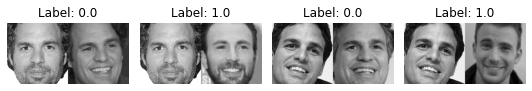

In [22]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

Inspect test pairs

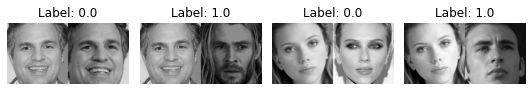

In [23]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

## Define the model

https://keras.io/examples/vision/siamese_contrastive/: "There are two input layers, each leading to its own network, which
produces embeddings.<br> A `Lambda` layer then merges them using an
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged output is fed to the final network."

In [24]:
# using early stopping to measure the performance of training time
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                              monitor='val_loss',
                              mode='min',
                              verbose = 1,
                              restore_best_weights=True)
callback=[early_stopping]

In [25]:
# CONTRASTIVE LOSS

# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(32, (3,3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, (3,3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(256, (3,3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(DIMENSION, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# both tower networks share same weights
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)

# define model for each loss function
siamese1 = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [26]:
# DICE LOSS

# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x2 = tf.keras.layers.BatchNormalization()(input2)
x2 = layers.Conv2D(32, (3,3), activation="relu")(x2)
x2 = layers.AveragePooling2D(pool_size=(2, 2))(x2)
x2 = layers.Conv2D(128, (3,3), activation="relu")(x2)
x2 = layers.AveragePooling2D(pool_size=(2, 2))(x2)
x2 = layers.Conv2D(256, (3,3), activation="relu")(x2)
x2 = layers.AveragePooling2D(pool_size=(2, 2))(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dense(32, activation="relu")(x2)
x2 = layers.Dense(DIMENSION, activation="relu")(x2)
embedding_network_2 = keras.Model(input2, x2)


input_1_2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# both tower networks share same weights
tower_1_2 = embedding_network_2(input_1_2)
tower_2_2 = embedding_network_2(input_2_2)

merge_layer_2 = layers.Lambda(euclidean_distance)([tower_1_2, tower_2_2])
normal_layer_2 = tf.keras.layers.BatchNormalization()(merge_layer_2)
output_layer_2 = layers.Dense(1, activation="sigmoid")(normal_layer_2)
siamese2 = keras.Model(inputs=[input_1_2, input_2_2], outputs=output_layer_2)

In [27]:
# BCE LOSS

# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input3 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x3 = tf.keras.layers.BatchNormalization()(input3)
x3 = layers.Conv2D(32, (3,3), activation="relu")(x3)
x3 = layers.AveragePooling2D(pool_size=(2, 2))(x3)
x3 = layers.Conv2D(128, (3,3), activation="relu")(x3)
x3 = layers.AveragePooling2D(pool_size=(2, 2))(x3)
x3 = layers.Conv2D(256, (3,3), activation="relu")(x3)
x3 = layers.AveragePooling2D(pool_size=(2, 2))(x3)
x3 = layers.Flatten()(x3)
x3 = layers.Dense(32, activation="relu")(x3)
x3 = layers.Dense(DIMENSION, activation="relu")(x3)
embedding_network_3 = keras.Model(input3, x3)

input_1_3 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_3 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# both tower networks share same weights
tower_1_3 = embedding_network_3(input_1_3)
tower_2_3 = embedding_network_3(input_2_3)

merge_layer_3 = layers.Lambda(euclidean_distance)([tower_1_3, tower_2_3])
normal_layer_3 = tf.keras.layers.BatchNormalization()(merge_layer_3)
output_layer_3 = layers.Dense(1, activation="sigmoid")(normal_layer_3)
siamese3 = keras.Model(inputs=[input_1_3, input_2_3], outputs=output_layer_3)

In [28]:
# BCE + DICE LOSS

# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input4 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x4 = tf.keras.layers.BatchNormalization()(input4)
x4 = layers.Conv2D(32, (3,3), activation="relu")(x4)
x4 = layers.AveragePooling2D(pool_size=(2, 2))(x4)
x4 = layers.Conv2D(128, (3,3), activation="relu")(x4)
x4 = layers.AveragePooling2D(pool_size=(2, 2))(x4)
x4 = layers.Conv2D(256, (3,3), activation="relu")(x4)
x4 = layers.AveragePooling2D(pool_size=(2, 2))(x4)
x4 = layers.Flatten()(x4)
x4 = layers.Dense(32, activation="relu")(x4)
x4 = layers.Dense(DIMENSION, activation="relu")(x4)
embedding_network_4 = keras.Model(input4, x4)


input_1_4 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_4 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# both tower networks share same weights
tower_1_4 = embedding_network_4(input_1_4)
tower_2_4 = embedding_network_4(input_2_4)

merge_layer_4 = layers.Lambda(euclidean_distance)([tower_1_4, tower_2_4])
normal_layer_4 = tf.keras.layers.BatchNormalization()(merge_layer_4)
output_layer_4 = layers.Dense(1, activation="sigmoid")(normal_layer_4)
siamese4 = keras.Model(inputs=[input_1_4, input_2_4], outputs=output_layer_4)

In [40]:
# Hinge loss

# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input5 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x5 = tf.keras.layers.BatchNormalization()(input5)
x5 = layers.Conv2D(32, (3,3), activation="relu")(x5)
x5 = layers.AveragePooling2D(pool_size=(2, 2))(x5)
x5 = layers.Conv2D(128, (3,3), activation="relu")(x5)
x5 = layers.AveragePooling2D(pool_size=(2, 2))(x5)
x5 = layers.Conv2D(256, (3,3), activation="relu")(x5)
x5 = layers.AveragePooling2D(pool_size=(2, 2))(x5)
x5 = layers.Flatten()(x5)
x5 = layers.Dense(32, activation="relu")(x5)
x5 = layers.Dense(DIMENSION, activation="relu")(x5)
embedding_network5 = keras.Model(input5, x5)


input_1_5 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_5 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# both tower networks share same weights
tower_1_5 = embedding_network5(input_1_5)
tower_2_5 = embedding_network5(input_2_5)

merge_layer_5 = layers.Lambda(euclidean_distance)([tower_1_5, tower_2_5])
normal_layer_5 = tf.keras.layers.BatchNormalization()(merge_layer_5)
output_layer_5 = layers.Dense(1, activation="sigmoid")(normal_layer_5)

# define model for each loss function
siamese5 = keras.Model(inputs=[input_1_5, input_2_5], outputs=output_layer_5)


## Define the Contrastive Loss: copied from https://keras.io/examples/vision/siamese_contrastive/

In [41]:

def contrastive_loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )   


    return contrastive_loss


## Define the Dice Loss
Code: https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras

![Dice Loss](./img/Dice_Loss.png)

In [42]:
# Dice Loss
def dice_loss(margin=1): #ignore margin

    smooth=1e-6

    def dice_coef(y_true, y_pred, smooth=100):        
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return dice
    
    def dice_coef_loss(y_true, y_pred):
        return 1 - dice_coef(y_true, y_pred)
    
    return dice_coef_loss

## Define the Binary Cross Entropy Loss
Code: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

![BCE Loss](./img/BCE_Loss.png)

In [43]:
# BCE_Loss
def BCE_loss(margin=1): #ignore margin

    def binary_cross_entropy_loss(y_true, y_pred):
        BCE =  K.binary_crossentropy(y_true, y_pred)
        return BCE
    
    return binary_cross_entropy_loss

## Define the BCE + Dice Loss
Paper: https://ieeexplore.ieee.org/abstract/document/10023508?casa_token=_zhnKjSaYgYAAAAA:zZ0oLIx6Yoc56OeYEdvdJfwA0FLyQyhg3NNmd8YOUTzPLLgn5hK8ZoJ4UUAwH_9Dn55YLj2fQbk 
Code: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

![Dice Loss](./img/BCE_Loss.png)
![Dice Loss](./img/Dice_Loss.png)
![Dice Loss](./img/BCE_Dice_Loss.png)

In [44]:
# BCE_Dice_Loss
def BCE_dice_loss(margin=1): #ignore margin

    smooth=1e-6

    def dice_coef_loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
        return dice

    
    def binary_cross_entropy_loss(y_true, y_pred):
        BCE =  K.binary_crossentropy(y_true, y_pred)
        return BCE
    

    def BCE_dice_coef_loss(y_true, y_pred):
        dice_loss = 1 - dice_coef_loss(y_true, y_pred)
        BCE =  binary_cross_entropy_loss(y_true, y_pred)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE
    
    return BCE_dice_coef_loss

## Define Hinge Loss

In [45]:
# Use Keras Hinge Loss

## Compile the model with the Contrastive Loss

In [46]:
siamese1.compile(loss=contrastive_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 20)           2700664     ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

## Compile the model with the Dice Loss

In [47]:
siamese2.compile(loss=dice_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 20)           2700664     ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

## Compile the model with the BCE Loss

In [48]:
siamese3.compile(loss=BCE_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_9 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 20)           2700664     ['input_8[0][0]',                
                                                                  'input_9[0][0]']          

## Compile the model with the BCE + Dice Loss

In [49]:
siamese4.compile(loss=BCE_dice_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese4.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 20)           2700664     ['input_11[0][0]',               
                                                                  'input_12[0][0]']         

## Compile the model with the Hinge Loss

In [50]:
siamese5.compile(loss=tf.keras.losses.Hinge(), optimizer="Adam", metrics=["accuracy"])
siamese5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_18 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_8 (Functional)           (None, 20)           2700664     ['input_17[0][0]',               
                                                                  'input_18[0][0]']         

## Train the Models

In [51]:
# Contrastive Loss
history1 = siamese1.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100


11/11 [==============================] - 31s 3s/step - loss: 0.2925 - accuracy: 0.4970 - val_loss: 0.4371 - val_accuracy: 0.5244
Epoch 2/100
11/11 [==============================] - 29s 3s/step - loss: 0.2828 - accuracy: 0.5274 - val_loss: 0.3485 - val_accuracy: 0.5488
Epoch 3/100
11/11 [==============================] - 29s 3s/step - loss: 0.2600 - accuracy: 0.6037 - val_loss: 0.3331 - val_accuracy: 0.5366
Epoch 4/100
11/11 [==============================] - 28s 3s/step - loss: 0.2320 - accuracy: 0.6433 - val_loss: 0.3537 - val_accuracy: 0.5488
Epoch 5/100
11/11 [==============================] - 27s 2s/step - loss: 0.2019 - accuracy: 0.6982 - val_loss: 0.3145 - val_accuracy: 0.5000
Epoch 6/100
11/11 [==============================] - 27s 2s/step - loss: 0.1809 - accuracy: 0.7256 - val_loss: 0.3040 - val_accuracy: 0.5854
Epoch 7/100
11/11 [==============================] - 28s 3s/step - loss: 0.1770 - accuracy: 0.7530 - val_loss: 0.2623 - val_accuracy: 0.6098
Epoch 8/100
11/11 [======

In [52]:
# Dice Loss
history2 = siamese2.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
11/11 [==============================] - 33s 3s/step - loss: 0.1191 - accuracy: 0.4878 - val_loss: 0.1289 - val_accuracy: 0.4756
Epoch 2/100
11/11 [==============================] - 31s 3s/step - loss: 0.1175 - accuracy: 0.5183 - val_loss: 0.1308 - val_accuracy: 0.4756
Epoch 3/100
11/11 [==============================] - 28s 3s/step - loss: 0.1157 - accuracy: 0.5183 - val_loss: 0.1302 - val_accuracy: 0.4512
Epoch 4/100
11/11 [==============================] - 30s 3s/step - loss: 0.1166 - accuracy: 0.5091 - val_loss: 0.1287 - val_accuracy: 0.4756
Epoch 5/100
11/11 [==============================] - 28s 3s/step - loss: 0.1117 - accuracy: 0.5640 - val_loss: 0.1280 - val_accuracy: 0.4512
Epoch 6/100
11/11 [==============================] - 31s 3s/step - loss: 0.1084 - accuracy: 0.5671 - val_loss: 0.1286 - val_accuracy: 0.4512
Epoch 7/100
11/11 [==============================] - 29s 3s/step - loss: 0.1062 - accuracy: 0.6067 - val_loss: 0.1325 - val_accuracy: 0.4512
Epoch 8/100
1

In [53]:
# BCE Loss
history3 = siamese3.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
11/11 [==============================] - 32s 3s/step - loss: 0.8895 - accuracy: 0.5000 - val_loss: 28.8102 - val_accuracy: 0.4756
Epoch 2/100
11/11 [==============================] - 30s 3s/step - loss: 0.8512 - accuracy: 0.5366 - val_loss: 11.5410 - val_accuracy: 0.4756
Epoch 3/100
11/11 [==============================] - 30s 3s/step - loss: 0.8149 - accuracy: 0.5671 - val_loss: 5.7904 - val_accuracy: 0.4634
Epoch 4/100
11/11 [==============================] - 28s 3s/step - loss: 0.7996 - accuracy: 0.5640 - val_loss: 4.5764 - val_accuracy: 0.4512
Epoch 5/100
11/11 [==============================] - 27s 2s/step - loss: 0.7567 - accuracy: 0.6128 - val_loss: 3.0451 - val_accuracy: 0.4390
Epoch 6/100
11/11 [==============================] - 30s 3s/step - loss: 0.7722 - accuracy: 0.5915 - val_loss: 1.9214 - val_accuracy: 0.4634
Epoch 7/100
11/11 [==============================] - 29s 3s/step - loss: 0.7427 - accuracy: 0.6067 - val_loss: 1.7687 - val_accuracy: 0.4634
Epoch 8/100

In [54]:
# BCE + Dice Loss
history4 = siamese4.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
11/11 [==============================] - 29s 3s/step - loss: 1.4441 - accuracy: 0.5213 - val_loss: 10.0006 - val_accuracy: 0.5244
Epoch 2/100
11/11 [==============================] - 28s 3s/step - loss: 1.3568 - accuracy: 0.5366 - val_loss: 3.1227 - val_accuracy: 0.5244
Epoch 3/100
11/11 [==============================] - 28s 3s/step - loss: 1.2991 - accuracy: 0.5518 - val_loss: 2.7815 - val_accuracy: 0.5244
Epoch 4/100
11/11 [==============================] - 28s 3s/step - loss: 1.2383 - accuracy: 0.5549 - val_loss: 2.2368 - val_accuracy: 0.5122
Epoch 5/100
11/11 [==============================] - 28s 3s/step - loss: 1.1259 - accuracy: 0.6189 - val_loss: 1.9205 - val_accuracy: 0.5366
Epoch 6/100
11/11 [==============================] - 28s 3s/step - loss: 1.0875 - accuracy: 0.6372 - val_loss: 1.7095 - val_accuracy: 0.5366
Epoch 7/100
11/11 [==============================] - 30s 3s/step - loss: 1.0386 - accuracy: 0.6463 - val_loss: 1.5001 - val_accuracy: 0.5488
Epoch 8/100


In [55]:
# Hinge Loss
history5 = siamese5.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
11/11 [==============================] - 31s 3s/step - loss: 1.0044 - accuracy: 0.4878 - val_loss: 0.9851 - val_accuracy: 0.5244
Epoch 2/100
11/11 [==============================] - 32s 3s/step - loss: 0.9875 - accuracy: 0.5183 - val_loss: 0.9801 - val_accuracy: 0.5244
Epoch 3/100
11/11 [==============================] - 30s 3s/step - loss: 0.9756 - accuracy: 0.5335 - val_loss: 0.9758 - val_accuracy: 0.5488
Epoch 4/100
11/11 [==============================] - 32s 3s/step - loss: 0.9647 - accuracy: 0.5518 - val_loss: 0.9713 - val_accuracy: 0.5610
Epoch 5/100
11/11 [==============================] - 29s 3s/step - loss: 0.9376 - accuracy: 0.6067 - val_loss: 0.9758 - val_accuracy: 0.5366
Epoch 6/100
11/11 [==============================] - 28s 3s/step - loss: 0.9189 - accuracy: 0.6524 - val_loss: 0.9749 - val_accuracy: 0.5610
Epoch 7/100
11/11 [==============================] - 30s 3s/step - loss: 0.9039 - accuracy: 0.6829 - val_loss: 0.9561 - val_accuracy: 0.5244
Epoch 8/100
1

## Visualize results: copied from https://keras.io/examples/vision/siamese_contrastive/

In [56]:
def plt_metric(history, metric, title, has_valid=True, x = 0, y = 0):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    axs[x, y].plot(history[metric])
    if has_valid:
        axs[x, y].plot(history["val_" + metric])
        axs[x, y].legend(["train", "validation"], loc="upper left")
    axs[x, y].set_title(title)
    
    for ax in axs.flat:
        ax.set(xlabel="epoch")
        
    axs.flat[0].set(ylabel="accuracy")
    axs.flat[6].set(ylabel="accuracy")
    axs.flat[3].set(ylabel="loss")
    axs.flat[9].set(ylabel="loss")
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()
        
    axs[x,y].set_xlim([0, 100])

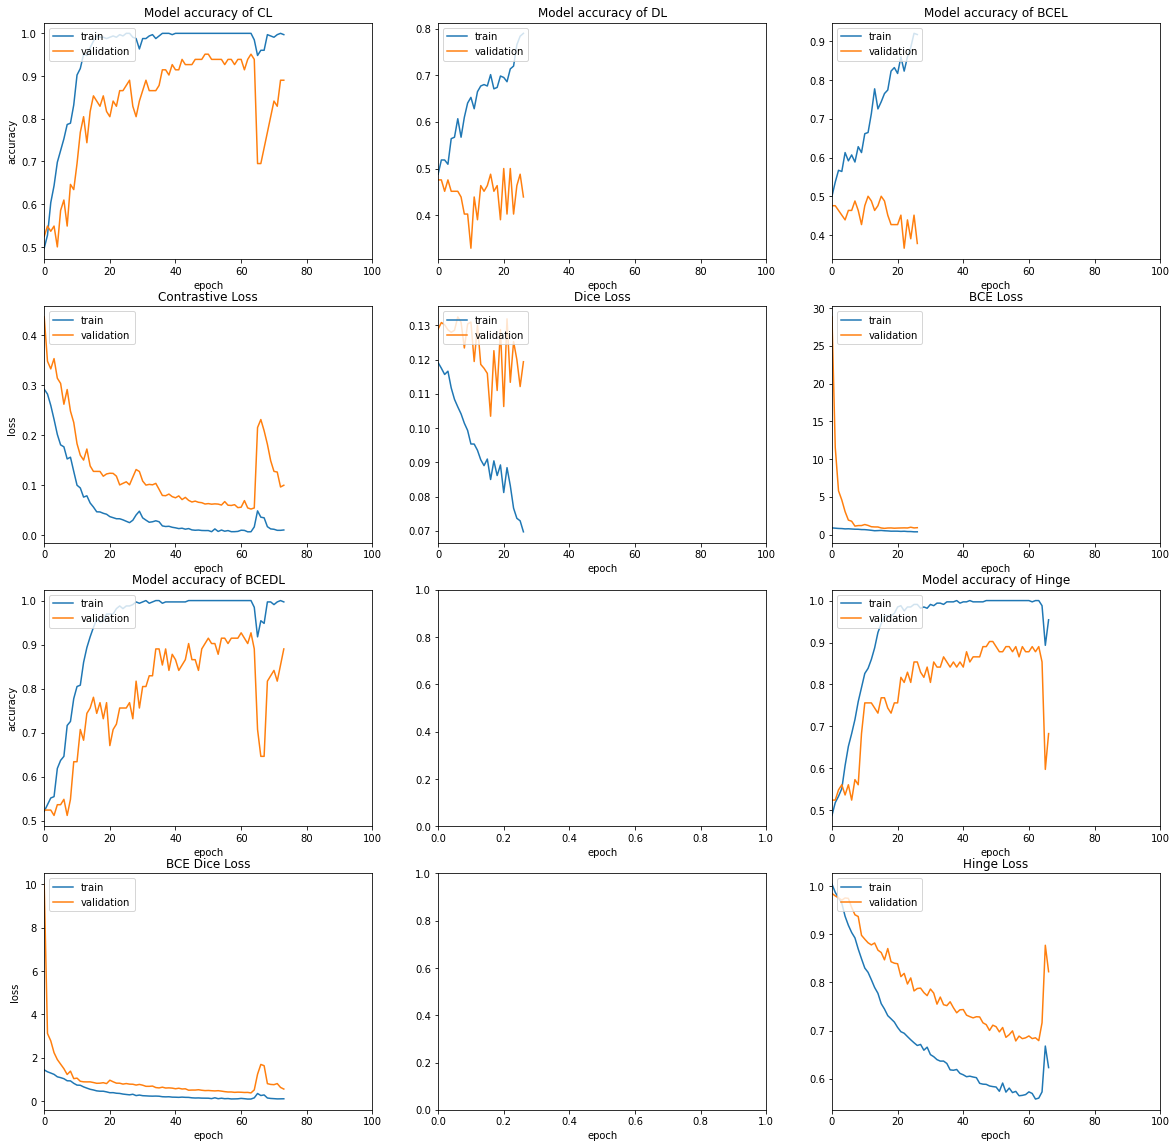

In [57]:
fig, axs = plt.subplots(4, 3)

fig.set_figheight(20)
fig.set_figwidth(20)

# Plot the accuracy of contrastive loss
plt_metric(history=history1.history, metric="accuracy", title="Model accuracy of CL", x=0 ,y=0)

# Plot the contrastive loss
plt_metric(history=history1.history, metric="loss", title="Contrastive Loss", x=1 ,y=0)

# Plot the accuracy of dice loss
plt_metric(history=history2.history, metric="accuracy", title="Model accuracy of DL",x=0 ,y=1)

# Plot the dice loss
plt_metric(history=history2.history, metric="loss", title="Dice Loss", x=1 ,y=1)

# Plot the accuracy of BCE loss
plt_metric(history=history3.history, metric="accuracy", title="Model accuracy of BCEL",x=0 ,y=2)

# Plot the BCE loss
plt_metric(history=history3.history, metric="loss", title="BCE Loss", x=1 ,y=2)

# Plot the accuracy of BCE dice loss
plt_metric(history=history4.history, metric="accuracy", title="Model accuracy of BCEDL", x=2 ,y=0)

# Plot the BCE dice loss
plt_metric(history=history4.history, metric="loss", title="BCE Dice Loss", x=3 ,y=0)

# Plot the accuracy of hinge loss
plt_metric(history=history5.history, metric="accuracy", title="Model accuracy of Hinge", x=2 ,y=2)

# Plot the hinge loss
plt_metric(history=history5.history, metric="loss", title="Hinge Loss", x=3 ,y=2)

## Plotting accuracy and change of train and validation loss over training process of all loss functions

In [58]:
def plt_metric_train(history, metric, title, has_valid=True, x = 0, y = 0):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    axs[x,y].plot(history[metric])
    
    axs[x,y].legend(["CL","DL","BCEL","BCEDL","Hinge"], loc="upper left")
    
    axs[x,y].set_title(title)
    
    for ax in axs.flat:
        ax.set(xlabel="epoch")
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()  
    
    axs[x,y].set_xlim([0, 100])
            
def plt_metric_val(history, metric, title, has_valid=True, x = 0, y = 0):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    axs[x,y].plot(history["val_" + metric])
    
    axs[x,y].legend(["CL","DL","BCEL","BCEDL","Hinge"], loc="upper left")
    
    axs[x,y].set_title(title)
        
    for ax in axs.flat:
        ax.set(xlabel="epoch")
                        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()
    
    axs[x,y].set_xlim([0, 100])

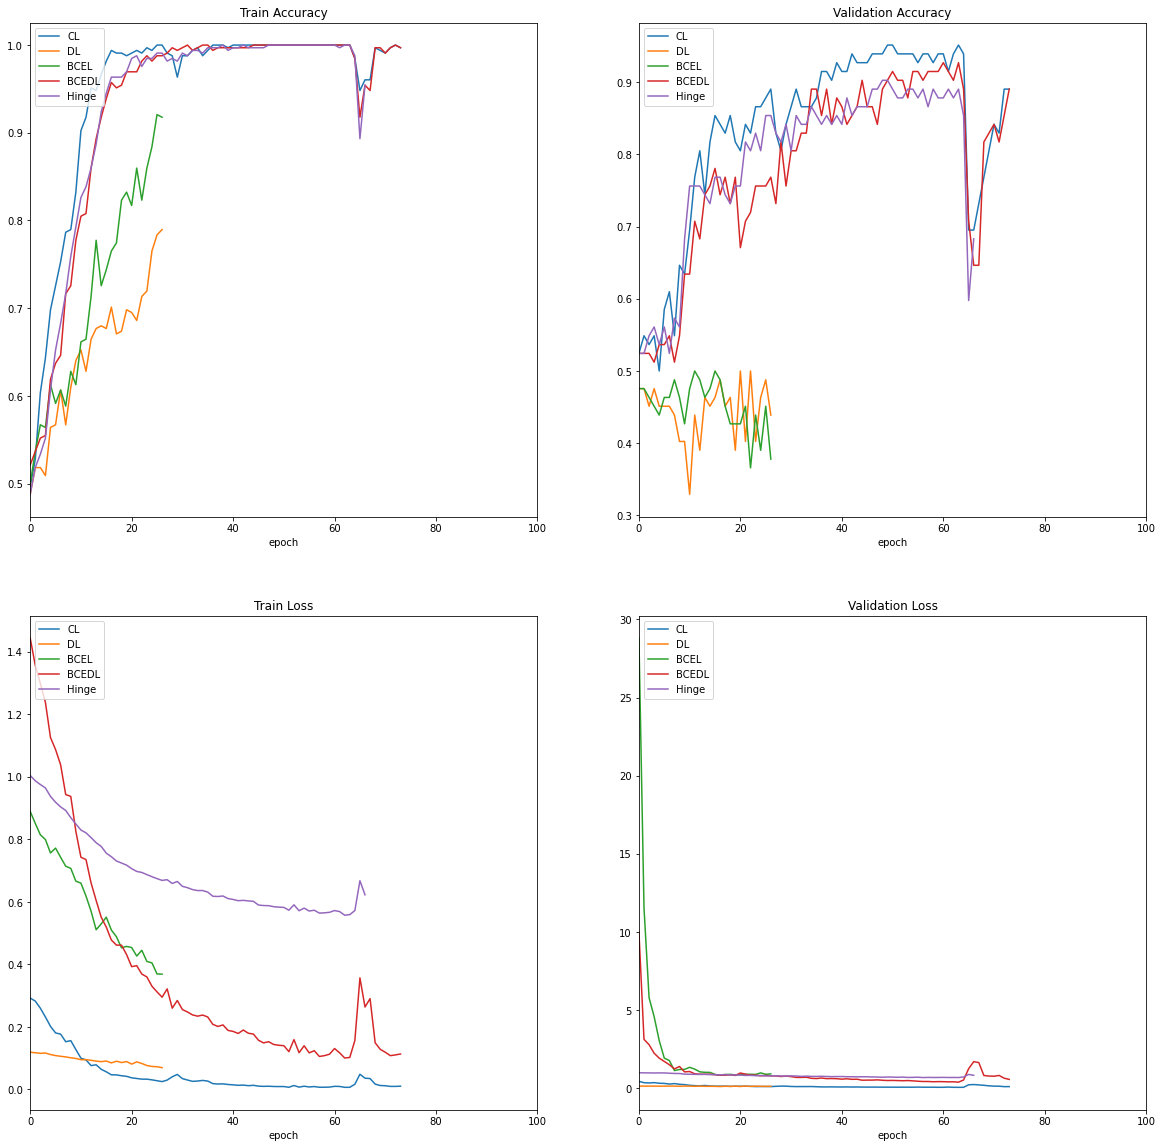

In [59]:
fig, axs = plt.subplots(2,2)

fig.set_figheight(20)
fig.set_figwidth(20)

# Plot the accuracy of contrastive loss
plt_metric_train(history=history1.history, metric="accuracy", title="Train Accuracy", x=0 ,y=0)

# Plot the accuracy of dice loss
plt_metric_train(history=history2.history, metric="accuracy", title="Train Accuracy",x=0 ,y=0)

# Plot the accuracy of BCE loss
plt_metric_train(history=history3.history, metric="accuracy", title="Train Accuracy",x=0 ,y=0)

# Plot the accuracy of BCE dice loss
plt_metric_train(history=history4.history, metric="accuracy", title="Train Accuracy", x=0 ,y=0)

# Plot the accuracy of hinge loss
plt_metric_train(history=history5.history, metric="accuracy", title="Train Accuracy", x=0 ,y=0)


# Plot the contrastive loss
plt_metric_train(history=history1.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the dice loss
plt_metric_train(history=history2.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the BCE loss
plt_metric_train(history=history3.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the BCE dice loss
plt_metric_train(history=history4.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the hinge loss
plt_metric_train(history=history5.history, metric="loss", title="Train Loss", x=1 ,y=0)


# Plot the accuracy of contrastive loss
plt_metric_val(history=history1.history, metric="accuracy", title="Validation Accuracy", x=0 ,y=1)

# Plot the accuracy of dice loss
plt_metric_val(history=history2.history, metric="accuracy", title="Validation Accuracy",x=0 ,y=1)

# Plot the accuracy of BCE loss
plt_metric_val(history=history3.history, metric="accuracy", title="Validation Accuracy",x=0 ,y=1)

# Plot the accuracy of BCE dice loss
plt_metric_val(history=history4.history, metric="accuracy", title="Validation Accuracy", x=0 ,y=1)

# Plot the accuracy of hinge loss
plt_metric_val(history=history5.history, metric="accuracy", title="Validation Accuracy", x=0 ,y=1)


# Plot the contrastive loss
plt_metric_val(history=history1.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the dice loss
plt_metric_val(history=history2.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the BCE loss
plt_metric_val(history=history3.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the BCE dice loss
plt_metric_val(history=history4.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the hinge loss
plt_metric_val(history=history5.history, metric="loss", title="Validation Loss", x=1 ,y=1)


## Evaluate the model

In [60]:
results1 = siamese1.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results1)

4/4 [==============================] - 3s 682ms/step - loss: 0.1769 - accuracy: 0.7302
test loss, test acc: [0.17686139047145844, 0.7301587462425232]


In [61]:
results2 = siamese2.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results2)

4/4 [==============================] - 3s 671ms/step - loss: 0.1204 - accuracy: 0.4524
test loss, test acc: [0.1204444169998169, 0.4523809552192688]


In [62]:
results3 = siamese3.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results3)

4/4 [==============================] - 3s 670ms/step - loss: 0.8649 - accuracy: 0.4921
test loss, test acc: [0.8649320006370544, 0.4920634925365448]


In [63]:
results4 = siamese4.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results4)

4/4 [==============================] - 3s 675ms/step - loss: 0.9258 - accuracy: 0.7222
test loss, test acc: [0.9258326292037964, 0.7222222089767456]


In [64]:
results5 = siamese5.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results5)

4/4 [==============================] - 3s 673ms/step - loss: 0.7818 - accuracy: 0.7460
test loss, test acc: [0.7818021774291992, 0.7460317611694336]


## Plotting test loss and test accuracy of all applied loss functions

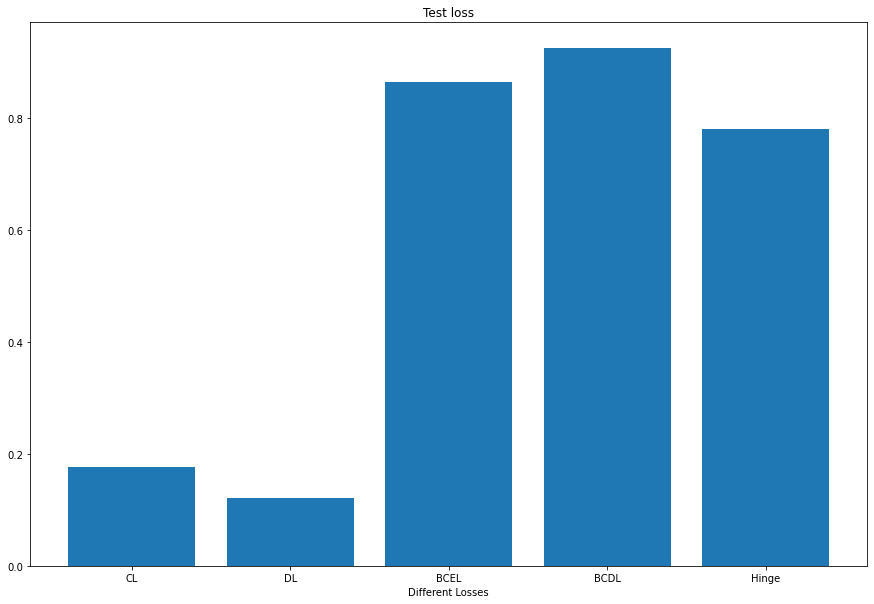

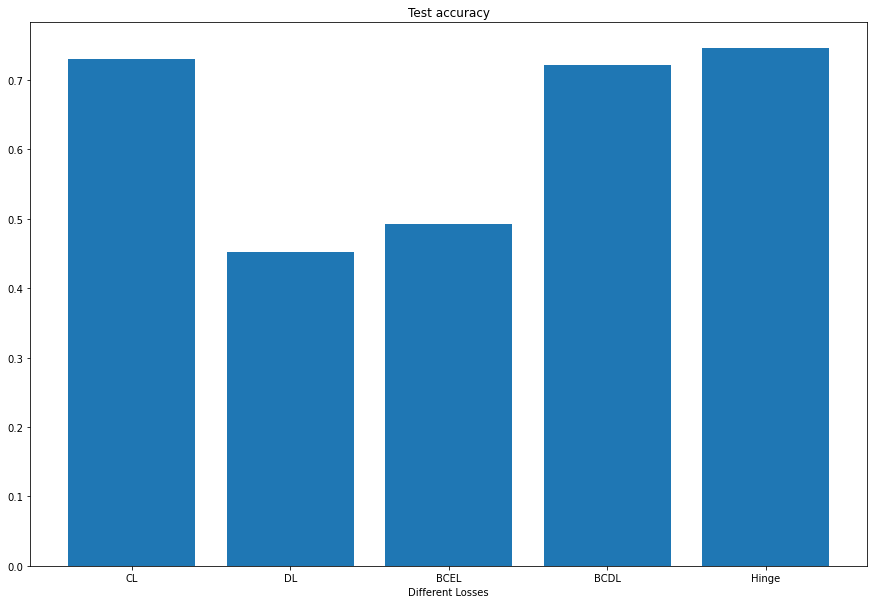

In [65]:
data = {'CL': results1[0], 'DL': results2[0], 'BCEL': results3[0],
        'BCDL': results4[0],'Hinge': results5[0]}
 
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize=(15, 10))
 
# creating the bar plot
plt.bar(courses, values)
 
plt.xlabel("Different Losses")
plt.ylabel("")
plt.title("Test loss")
plt.show()

data = {'CL': results1[1], 'DL': results2[1], 'BCEL': results3[1],
        'BCDL': results4[1],
        'Hinge': results5[1]}
 
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize=(15, 10))
 
# creating the bar plot
plt.bar(courses, values)
 
plt.xlabel("Different Losses")
plt.ylabel("")
plt.title("Test accuracy")
plt.show()

## Model Structure

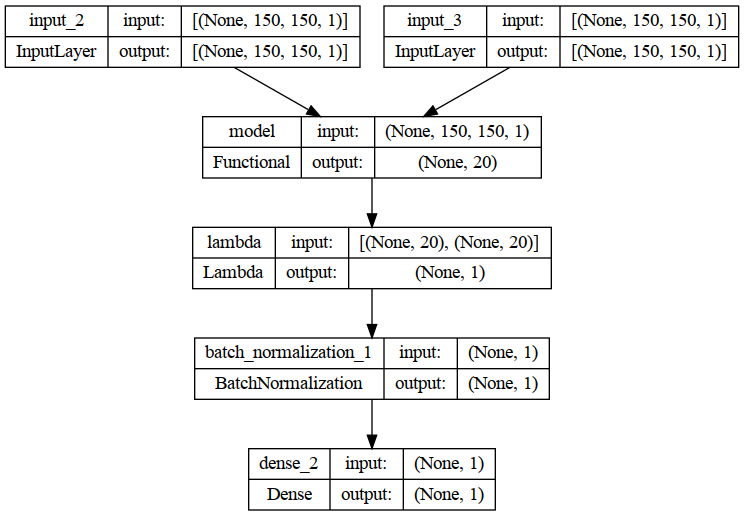

In [66]:
plot_model (siamese1, show_shapes=True, to_file='model.png')

## Visualize the predictions

4/4 [==============================] - 3s 755ms/step


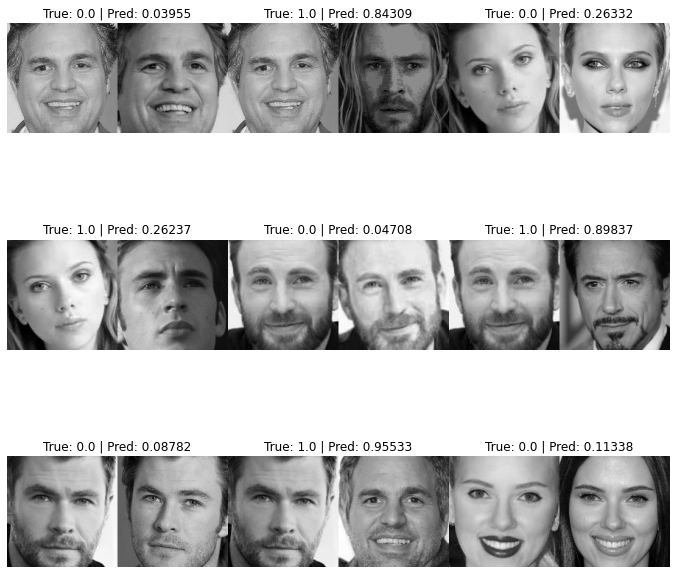

In [67]:
predictions = siamese1.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions, test=True)

4/4 [==============================] - 3s 749ms/step


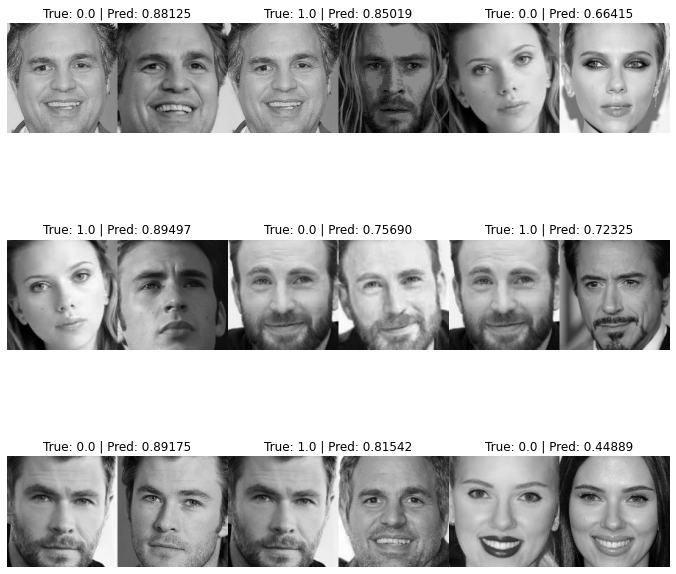

In [68]:
predictions2 = siamese2.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions2, test=True)

4/4 [==============================] - 3s 676ms/step


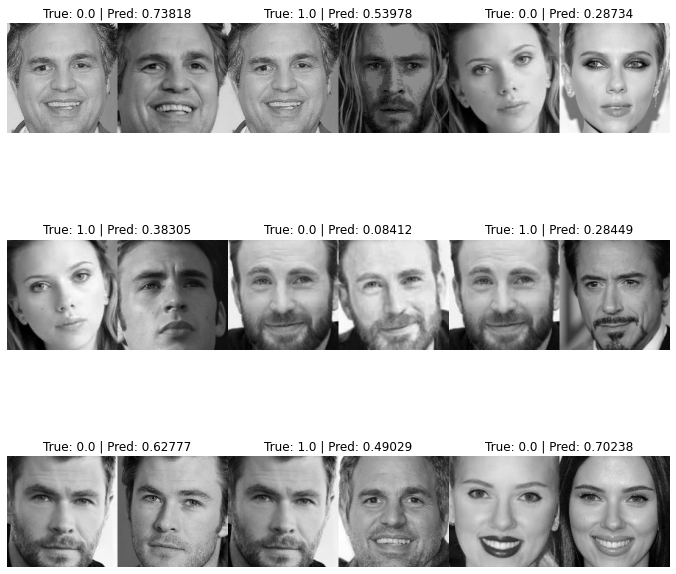

In [69]:
predictions3 = siamese3.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions3, test=True)

4/4 [==============================] - 3s 681ms/step


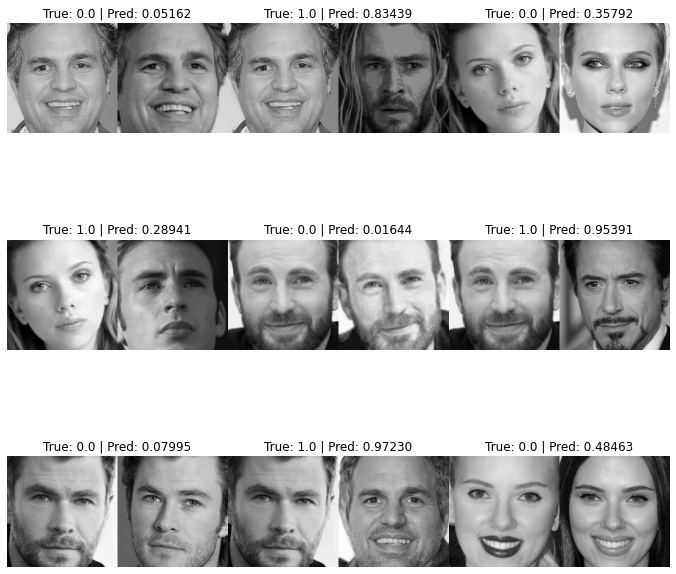

In [70]:
predictions4 = siamese4.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions4, test=True)

4/4 [==============================] - 3s 674ms/step


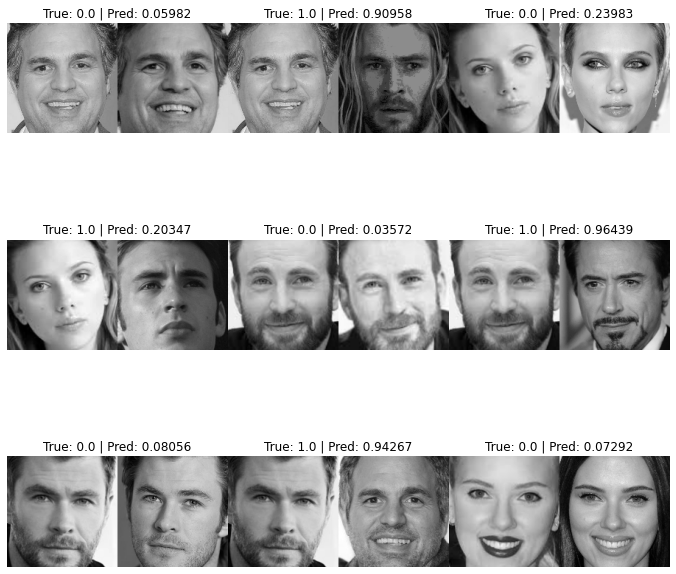

In [71]:
predictions5 = siamese5.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions5, test=True)